In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import preprocess_input, decode_predictions

import tensorflow as tf
tf.keras.applications.inception_v3.preprocess_input
from tensorflow.keras.applications import DenseNet169,MobileNet,NASNetMobile,Xception,InceptionV3
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
disease_types=['normal', 'abnormal']
data_dir = 'dir/'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,normal/NR1_4CH_0.jpg,0,normal
1,normal/NR1_4CH_1.jpg,0,normal
2,normal/NR1_4CH_10.jpg,0,normal
3,normal/NR1_4CH_100.jpg,0,normal
4,normal/NR1_4CH_101.jpg,0,normal


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,abnormal/AVSD6_4CH_43.jpg,1,abnormal
1,normal/NR1_4CH_69.jpg,0,normal
2,normal/NR4_4CH_33.jpg,0,normal
3,normal/NR2_4CH_121.jpg,0,normal
4,normal/NR1_4CH_21.jpg,0,normal


In [5]:
print (train)

                           File  DiseaseID Disease Type
0     abnormal/AVSD6_4CH_43.jpg          1     abnormal
1         normal/NR1_4CH_69.jpg          0       normal
2         normal/NR4_4CH_33.jpg          0       normal
3        normal/NR2_4CH_121.jpg          0       normal
4         normal/NR1_4CH_21.jpg          0       normal
...                         ...        ...          ...
1324     abnormal/VSD1_2069.jpg          1     abnormal
1325   abnormal/VSD2_4CH_11.jpg          1     abnormal
1326   abnormal/VSD3_4CH_27.jpg          1     abnormal
1327  abnormal/AVSD5_4CH_43.jpg          1     abnormal
1328     abnormal/VSD1_2163.jpg          1     abnormal

[1329 rows x 3 columns]


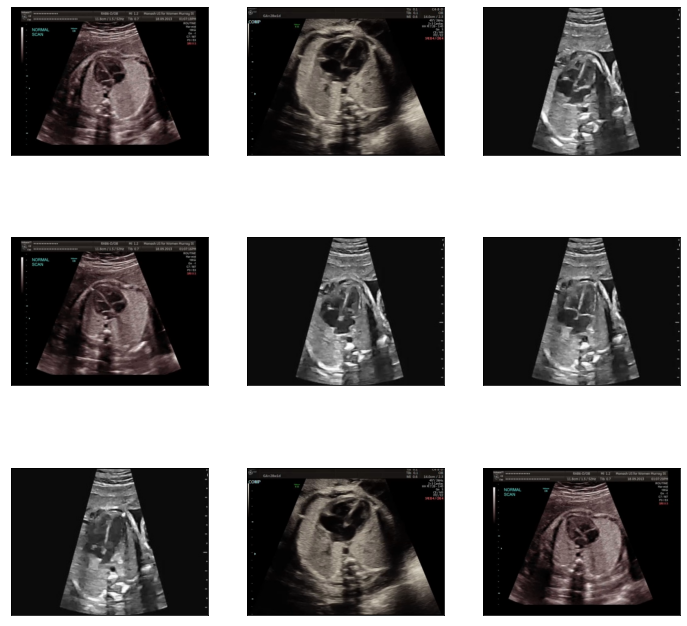

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('normal', 3, 3)

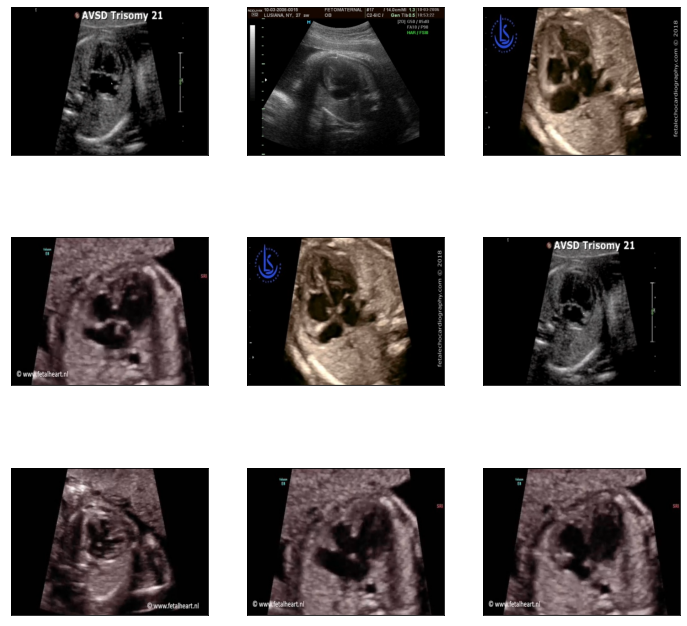

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('abnormal', 3, 3)

In [8]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

1329it [00:05, 234.50it/s]

Train Shape: (1329, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(1329, 2)


In [11]:
BATCH_SIZE = 16

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


In [12]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1063, 64, 64, 3)
X_val: (266, 64, 64, 3)
Y_train: (1063, 2)
Y_val: (266, 2)


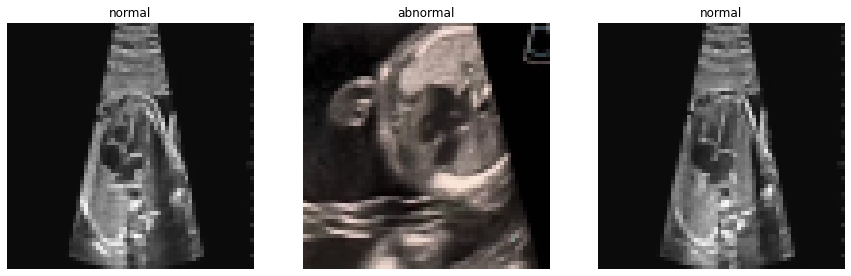

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [14]:
EPOCHS = 200
SIZE=None
N_ch=3

In [15]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_resnet50_1802_b16_new.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     84        
_________________________________________________________________
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

In [17]:
# from keras.utils import plot_model
# from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png') 

In [18]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
64/66 [============================>.] - ETA: 0s - loss: 1.0521 - accuracy: 0.5754
Epoch 00001: val_loss improved from inf to 0.81133, saving model to model_resnet50_1802_b16_new.h5
66/66 [==============================] - 4s 66ms/step - loss: 1.0507 - accuracy: 0.5750 - val_loss: 0.8113 - val_accuracy: 0.5338 - lr: 0.0010
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7297
Epoch 00002: val_loss did not improve from 0.81133
66/66 [==============================] - 2s 26ms/step - loss: 0.6632 - accuracy: 0.7297 - val_loss: 2.5768 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.8196
Epoch 00003: val_loss improved from 0.81133 to 0.69859, saving model to model_resnet50_1802_b16_new.h5
66/66 [==============================] - 4s 64ms/step - loss: 0.4406 - accuracy: 0.8223 - val_loss: 

Epoch 27/200
64/66 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9862
Epoch 00027: val_loss did not improve from 0.00009
66/66 [==============================] - 2s 26ms/step - loss: 0.0391 - accuracy: 0.9857 - val_loss: 2.5351e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 28/200
66/66 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9866
Epoch 00028: val_loss did not improve from 0.00009
66/66 [==============================] - 2s 26ms/step - loss: 0.0329 - accuracy: 0.9866 - val_loss: 6.1811e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 29/200
65/66 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9922 ETA: 0s - loss: 0.0211 - accu
Epoch 00029: val_loss did not improve from 0.00009
66/66 [==============================] - 2s 26ms/step - loss: 0.0201 - accuracy: 0.9914 - val_loss: 6.9027e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 30/200
65/66 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy:

Epoch 80/200
65/66 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990
Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00080: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 1.7952e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 81/200
64/66 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9970
Epoch 00081: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0058 - accuracy: 0.9971 - val_loss: 2.4268e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 82/200
64/66 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 00082: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 9.3213e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 83/200
66/66 [==============================] -

Epoch 107/200
64/66 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9941
Epoch 00107: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0573 - accuracy: 0.9914 - val_loss: 0.1037 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 108/200
65/66 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9971
Epoch 00108: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0136 - accuracy: 0.9971 - val_loss: 0.0073 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 109/200
65/66 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9981
Epoch 00109: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0134 - accuracy: 0.9981 - val_loss: 0.0030 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 110/200
65/66 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9971
Epoch 00110: ReduceLROnPlateau

Epoch 134/200
66/66 [==============================] - ETA: 0s - loss: 9.7193e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.4135e-04 - accuracy: 1.0000
Epoch 00134: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 9.4135e-04 - accuracy: 1.0000 - val_loss: 1.0541e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 135/200
65/66 [============================>.] - ETA: 0s - loss: 9.3365e-04 - accuracy: 1.0000
Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00135: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 9.1978e-04 - accuracy: 1.0000 - val_loss: 3.9803e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 136/200
66/66 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990
Epoch 00136: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 27ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 3.9800e-05 - val_accuracy: 1.0000 -

Epoch 161/200
65/66 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9981
Epoch 00161: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0038 - accuracy: 0.9981 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 162/200
66/66 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 00162: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 163/200
64/66 [============================>.] - ETA: 0s - loss: 8.7850e-04 - accuracy: 1.0000
Epoch 00163: val_loss did not improve from 0.00001
66/66 [==============================] - 2s 26ms/step - loss: 8.8757e-04 - accuracy: 1.0000 - val_loss: 4.4597e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 164/200
64/66 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 00164: val_l

In [19]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

9/9 [==============================] - 0s 8ms/step - loss: 1.6939e-04 - accuracy: 1.0000
Final Loss: 0.00016938545741140842, Final Accuracy: 1.0


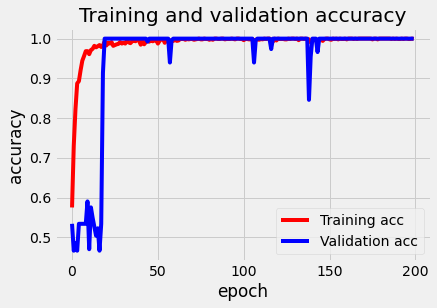

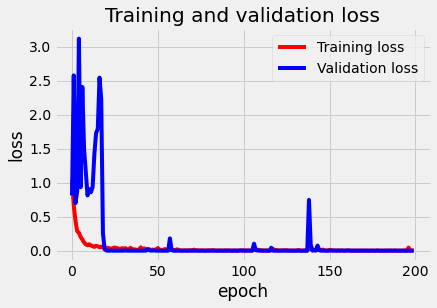

In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Graphing our training and validation
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.savefig('plotting akurasi model mobilenet_b64.png')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.savefig('plotting loss model Resnet_b16.png')
plt.show()


Confusion Matrix
[[124   0]
 [  0 142]]


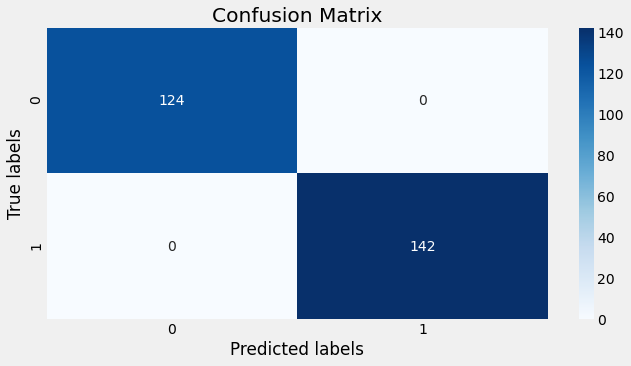

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import seaborn as sns

Y_true = np.argmax(Y_val, axis=1)
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(Y_true, Y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt=".0f")

# labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
plt.savefig('cm model resnet50_16blue.png')

# ticks
# ax.xaxis.set_ticklabels(list(test_generator.class_indices.keys()))
# ax.yaxis.set_ticklabels(list(test_generator.class_indices.keys()))
plt.show()


In [24]:
tp = cm[0,0]
tn = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
#print(cm)

precision = tp / ( tp + fp)
recall = tp/(tp+fn)
spesifisitas = tn / (tn+fp)
f1=(2*precision*recall)/ (precision+recall)
akurasi = (tp+tn)/(tp+tn+fp+fn)
all_hasil = [recall,precision,spesifisitas,akurasi,f1]

print ("presisi : ",precision*100)
print ("spesifisitas : ",spesifisitas*100)
print("recall : ",recall*100)
print ("F1 : ",f1*100)
print("akurasi : ",akurasi*100)

presisi :  100.0
spesifisitas :  100.0
recall :  100.0
F1 :  100.0
akurasi :  100.0


# Normal

[0.9521542  0.04784576]


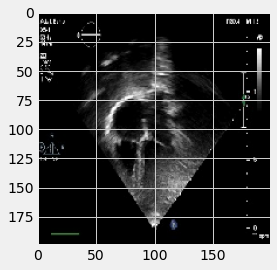

Prediksi
Prediction: normal



In [67]:
# img = image.load_img('dir', grayscale=False, target_size=(64, 64))
# show_img=image.load_img('dir', grayscale=False, target_size=(200, 200))
# disease_class=['normal','abnormal']
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)
# x /= 255

# custom = model.predict(x)
# print(custom[0])

# plt.imshow(show_img)
# plt.show()

# a=custom[0]
# ind=np.argmax(a)
# print('Prediksi')
# print('Prediction:',disease_class[ind])
# print()

